# Sex Prediction
Total data size is n=500 from UK Biobank, consisting of Structural, resting state functional, and diffusion-weighted MRI with Demographic information. 

Each dataset, train and test, includes 'Images' and matched 'Features'; 
- Grey Matter Map (GM)
- White Matter Map (WM)
- Fractional Anisotropy Map (FA)
- Mean Diffusivity Map (MD)


&rarr; Goal: Predict the given subject's sex.

### Import Modules & Basic Settings

In [80]:
import os, time
import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy

import nibabel as nib

# from monai.utils import set_determinism
# set_determinism(seed=0)

# %pip install nilearn

# from nilearn import plotting
# import nilearn.image as nli

import shap

import warnings
warnings.filterwarnings('ignore')

### Set Options

In [81]:
# GPU Setting
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Device:', device)

# Base Directory
root_dir = '/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/jw/dt/'
os.chdir(root_dir)
print(os.getcwd())

# Path to Data
image_data = 'data/images/'
train_data_path = root_dir+image_data+'train/'
test_data_path = root_dir+image_data+'test/'

# Selected Modalities
modalities = ["GM", "MD", "WM"] #,"FA"]
additional_variables = ["Sex", "Age"]

Device: cuda
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/jw/dt


In [179]:
# Hyper-Parameters Setting
batch_size = 4
max_epochs = 100
learning_rate = 1e-4
weight_decay = 1e-5
val_interval = 1

### Load Train Data

In [181]:
# Data Transform
class ToTensor3D:
    def __call__(self, image):
        return torch.from_numpy(image).float()

class Normalize3D:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.sub_(m).div_(s)
        return tensor

mean = [0.5] * len(modalities) 
std = [0.5] * len(modalities) 

from torchvision import transforms
transform = transforms.Compose([
    ToTensor3D(),
    Normalize3D(mean, std)
])

In [182]:
class CustomDataset(Dataset):
    def __init__(self, data, modalities, additional_variables, transform=None):
        self.data = data
        self.modalities = modalities
        self.additional_variables = additional_variables
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        images = []

        for modality in self.modalities:
            image_path = sample[modality]
            image = nib.load(image_path).get_fdata()
            image = np.expand_dims(image, axis=0)  # Add channel dimension
            if self.transform:
                image = self.transform(image)
            images.append(image)    # (3, 79, 95, 79)

        images = np.concatenate(images, axis=0)
        images = torch.tensor(images, dtype=torch.float32)

        additional_data = []
        for var in self.additional_variables:
            if var != 'Sex':
                additional_data.append(sample[var])
        additional_data = torch.tensor(additional_data, dtype=torch.float32)
        sex = torch.tensor(sample['Sex'], dtype=torch.long)

        return images, additional_data, sex
        #return {'images': torch.tensor(images, dtype=torch.float32), 'additional_data': additional_data, 'Sex': sex}

    

In [183]:
# Load Data (Train)
train_df = pd.read_csv(os.path.join(train_data_path, 'Subjects.csv'))
print(train_df.head())
train_subjects = train_df['ID'].to_numpy()
train_data_dicts = []

for index, subject in enumerate(train_subjects):
    subject_dict = {}
    for modality in modalities:
        subject_dict[modality] = os.path.join(train_data_path, modality, f"{subject:03d}.nii.gz")
    for variable in additional_variables:
        subject_dict[variable] = train_df[variable].to_numpy()[index]
    train_data_dicts.append(subject_dict)

# Convert the Format of Dictionary to Split the Dataset 
train_data_df = pd.DataFrame(train_data_dicts)
train_data, val_data = train_test_split(train_data_df, test_size=0.2, random_state=42)
train_data_dicts, val_data_dicts = train_data.to_dict('records'), val_data.to_dict('records')

train_dataset = CustomDataset(train_data_dicts, modalities, additional_variables, transform=transform)
val_dataset = CustomDataset(val_data_dicts, modalities, additional_variables, transform=transform)


   ID  Sex  Age
0   1    1   55
1   2    0   54
2   3    1   54
3   4    1   55
4   5    1   57


In [184]:
# Define Data Loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0, pin_memory=torch.cuda.is_available())

/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/jw/dt/data/images/train/GM/006.nii.gz
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/jw/dt/data/images/train/MD/006.nii.gz
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/jw/dt/data/images/train/WM/006.nii.gz


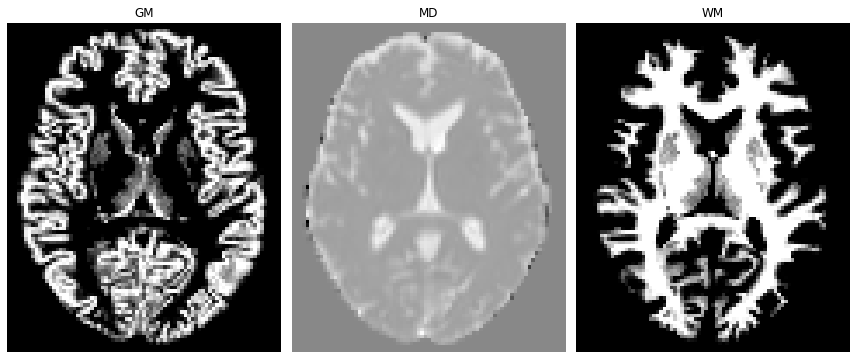

In [185]:
# Visualize
fig, axes = plt.subplots(1, len(modalities), figsize=(len(modalities) * 4, 5))
for i, key in enumerate(modalities):
    print(train_data_dicts[0][key])
    image = nib.load(train_data_dicts[0][key]).get_fdata()[:, :, :]
    slice_2d = np.squeeze(image[:, :, image.shape[2] // 2])
    axes[i].imshow(np.rot90(slice_2d), cmap='gray')
    axes[i].set_title(key)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

### Model

In [186]:
class CustomRegressor(nn.Module):
    ### Confirm Params
    def __init__(self, input_channels=3, additional_features=1, out_features=2):
        super(CustomRegressor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv3d(input_channels, 16, kernel_size=3, stride=2, padding=1), # input: 79x95x79
            nn.ReLU(),
            nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1), # input: 40x48x40
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1), # input: 20x24x20
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1), # input: 10x12x10
            nn.ReLU(),
            nn.Conv3d(128, 256, kernel_size=3, stride=2, padding=1), # input: 5x6x5 --> output: 2x3x2
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 3 * 3 * 3 + additional_features, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, out_features)
        )

    def forward(self, x, y):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.cat((x, y), dim=1)
        x = self.fc_layers(x)
        #x = 
        return x

In [187]:
# Model, Optimizer, and Scheduler Setup
criterion = torch.nn.CrossEntropyLoss()
model = CustomRegressor(input_channels=len(modalities), additional_features=1, out_features=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
metric = Accuracy(task='binary').to(device)
#scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

In [188]:
torch.__version__
# ㅊ

'1.13.1+cu117'

In [189]:
#CUDA 11.2, cudnn 8.1

In [190]:
# Training Loop
start_time = time.time()
best_metric, best_metric_epoch = -1, -1
epoch_loss_values, epoch_metric_values, metric_values = [], [], []

for epoch in range(10):
    model.train()
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    epoch_start_time = time.time()

    cnt= 0
    for batch_ in train_loader:
        optimizer.zero_grad()
        
        images = batch_[0].to(device)
        additional_data = batch_[1].to(device)
        labels = batch_[2].to(device)

        cnt += 1 
        print(cnt)
        print(images.shape)
        if cnt > 3:
            break

1
torch.Size([4, 3, 79, 95, 79])
2
torch.Size([3, 3, 79, 95, 79])
1
torch.Size([4, 3, 79, 95, 79])
2
torch.Size([3, 3, 79, 95, 79])
1
torch.Size([4, 3, 79, 95, 79])
2
torch.Size([3, 3, 79, 95, 79])
1
torch.Size([4, 3, 79, 95, 79])
2
torch.Size([3, 3, 79, 95, 79])
1
torch.Size([4, 3, 79, 95, 79])
2
torch.Size([3, 3, 79, 95, 79])
1
torch.Size([4, 3, 79, 95, 79])
2
torch.Size([3, 3, 79, 95, 79])
1
torch.Size([4, 3, 79, 95, 79])
2
torch.Size([3, 3, 79, 95, 79])
1
torch.Size([4, 3, 79, 95, 79])
2
torch.Size([3, 3, 79, 95, 79])
1
torch.Size([4, 3, 79, 95, 79])
2
torch.Size([3, 3, 79, 95, 79])
1
torch.Size([4, 3, 79, 95, 79])
2
torch.Size([3, 3, 79, 95, 79])


In [194]:
# Training Loop
start_time = time.time()
best_metric, best_metric_epoch = -1, -1
epoch_loss_values, epoch_metric_values, metric_values = [], [], []

for epoch in range(100):
    model.train()
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    epoch_start_time = time.time()

    for batch_data in train_loader:
        optimizer.zero_grad()
        
        images = batch_data[0].to(device)
        additional_data = batch_data[1].to(device)
        labels = batch_data[2].to(device)

        outputs = model(images, additional_data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)
        total_samples += images.size(0)
        correct_predictions += (outputs.argmax(dim=1) == labels).sum().item()

    epoch_loss /= total_samples
    epoch_accuracy = correct_predictions / total_samples

    epoch_loss_values.append(epoch_loss)
    epoch_metric_values.append(epoch_accuracy)

    print(f'Epoch {epoch+1}/{max_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # lr_scheduler.step()
        # image_inputs = torch.cat(images, dim=1)
        # variables = [batch_data[variable].view(-1,1).to(device) for variable in additional_variables if variable != 'Sex']
        # variable_inputs = torch.cat(variables, dim=1)
        
        # outputs = model(image_inputs, variable_inputs)
        # loss = criterion(outputs, labels)
        
        # loss.backward()
        # optimizer.step()
        
        # epoch_loss += loss.item()
        # _, predicted = torch.max(outputs.data, 1)
        # correct_predictions += (predicted == labels).sum().item()
        # total_samples += labels.size(0)


    
    # epoch_loss, epoch_metric = 10, 10

Epoch 1/100, Loss: 0.3795, Accuracy: 0.8571
Epoch 2/100, Loss: 0.4629, Accuracy: 0.8571
Epoch 3/100, Loss: 0.3715, Accuracy: 0.8571
Epoch 4/100, Loss: 0.4401, Accuracy: 0.8571
Epoch 5/100, Loss: 0.4178, Accuracy: 0.8571
Epoch 6/100, Loss: 0.4707, Accuracy: 0.8571
Epoch 7/100, Loss: 0.3773, Accuracy: 0.8571
Epoch 8/100, Loss: 0.4116, Accuracy: 0.8571
Epoch 9/100, Loss: 0.3661, Accuracy: 0.8571
Epoch 10/100, Loss: 0.4250, Accuracy: 0.8571
Epoch 11/100, Loss: 0.4588, Accuracy: 0.8571
Epoch 12/100, Loss: 0.3161, Accuracy: 0.8571
Epoch 13/100, Loss: 0.3974, Accuracy: 0.8571
Epoch 14/100, Loss: 0.4514, Accuracy: 0.8571
Epoch 15/100, Loss: 0.3755, Accuracy: 0.8571
Epoch 16/100, Loss: 0.3761, Accuracy: 0.8571
Epoch 17/100, Loss: 0.4616, Accuracy: 0.8571
Epoch 18/100, Loss: 0.3875, Accuracy: 0.8571
Epoch 19/100, Loss: 0.3872, Accuracy: 0.8571
Epoch 20/100, Loss: 0.3772, Accuracy: 0.8571
Epoch 21/100, Loss: 0.4582, Accuracy: 0.8571
Epoch 22/100, Loss: 0.3137, Accuracy: 0.8571
Epoch 23/100, Loss:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:14                                                                                   │
│                                                                                                  │
│ /mnt/hdd/eric/.conda/envs/8.tmp.copied/lib/python3.8/site-packages/torch/utils/data/dataloader.p │
│ y:628 in __next__                                                                                │
│                                                                                                  │
│    625 │   │   │   if self._sampler_iter is None:                                                │
│    626 │   │   │   │   # TODO(https://github.com/pytorch/pytorch/issues/76750)                   │
│    627 │   │   │   │   self._reset()  # type: ignore[call-arg]                                   │
│ ❱  628 │   │   │   data = self._next_data()                                                      │
│    629 │   │   │   self._num_yielded += 1                                                        │
│    630 │   │   │   if self._dataset_kind == _DatasetKind.Iterable and \                          │
│    631 │   │   │   │   │   self._IterableDataset_len_called is not None and \                    │
│                                                                                                  │
│ /mnt/hdd/eric/.conda/envs/8.tmp.copied/lib/python3.8/site-packages/torch/utils/data/dataloader.p │
│ y:671 in _next_data                                                                              │
│                                                                                                  │
│    668 │                                                                                         │
│    669 │   def _next_data(self):                                                                 │
│    670 │   │   index = self._next_index()  # may raise StopIteration                             │
│ ❱  671 │   │   data = self._dataset_fetcher.fetch(index)  # may raise StopIteration              │
│    672 │   │   if self._pin_memory:                                                              │
│    673 │   │   │   data = _utils.pin_memory.pin_memory(data, self._pin_memory_device)            │
│    674 │   │   return data                                                                       │
│                                                                                                  │
│ /mnt/hdd/eric/.conda/envs/8.tmp.copied/lib/python3.8/site-packages/torch/utils/data/_utils/fetch │
│ .py:58 in fetch                                                                                  │
│                                                                                                  │
│   55 │   │   │   if hasattr(self.dataset, "__getitems__") and self.dataset.__getitems__:         │
│   56 │   │   │   │   data = self.dataset.__getitems__(possibly_batched_index)                    │
│   57 │   │   │   else:                                                                           │
│ ❱ 58 │   │   │   │   data = [self.dataset[idx] for idx in possibly_batched_index]                │
│   59 │   │   else:                                                                               │
│   60 │   │   │   data = self.dataset[possibly_batched_index]                                     │
│   61 │   │   return self.collate_fn(data)                                                        │
│                                                                                                  │
│ /mnt/hdd/eric/.conda/envs/8.tmp.copied/lib/python3.8/site-packages/torch/utils/data/_utils/fetch │
│ .py:58 in <listcomp>                                                                             │
│                                                                                                  │
│   55 │   │   │   if hasattr(self.dataset, "__getitems__") a

In [ ]:
def train_one_epoch(model, device, train_loader, modalities, additional_variables, optimizer, criterion, metric, scaler):
    model.train()
    epoch_loss = 0.0
    metric.reset()
    for batch_data in train_loader:
        labels = batch_data['Sex'].to(device)
        images = [batch_data[modality].to(device) for modality in modalities]
        image_inputs = torch.cat(images, dim=1)
        variables = [batch_data[variable].view(-1,1).to(device) for variable in additional_variables if variable != 'Sex']
        variable_inputs = torch.cat(variables, dim=1)
        current_batch_size = labels.size(0)
        optimizer.zero_grad()
        outputs = model(image_inputs, variable_inputs)
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss = criterion(outputs, labels)
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        epoch_loss += loss.item()
        metric(outputs[:, 1].reshape(current_batch_size, -1), labels.reshape(current_batch_size, -1))
    epoch_metric = metric.compute().item()
    return epoch_loss / len(train_loader), epoch_metric

In [ ]:
# model, epoch_loss_values, epoch_metric_values, metric_values = train_model(model_path, device, train_loader, val_loader,
#     modalities, additional_variables, logger, criterion, max_epochs, learning_rate, weight_decay, val_interval)
# plot_metric_values(model_path, epoch_loss_values, epoch_metric_values, metric_values, val_interval)

### Train?

In [ ]:


# def train_model(model_path, device, train_loader, val_loader, modalities, additional_variables, logger,
# criterion=torch.nn.CrossEntropyLoss(), max_epochs=100, learning_rate=1e-4, weight_decay=1e-5, val_interval=1):
    # model = CustomRegressor(
    #     input_channels=len(modalities),
    #     image_features=64,
    #     additional_features=1,
    #     out_features=2).to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
    # metric = Accuracy(task='binary').to(device)
    # scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    # # start_time = time.time()
    # best_metric = -1
    # best_metric_epoch = -1
early_stopping = EarlyStopping(patience=30, delta=0)
# epoch_loss_values, epoch_metric_values, metric_values = [], [], []
for epoch in range(max_epochs):
    epoch_start_time = time.time()
    epoch_loss, epoch_metric = train_one_epoch(model, device, train_loader, modalities, additional_variables, optimizer, criterion, metric, scaler)
    epoch_loss_values.append(epoch_loss)
    epoch_metric_values.append(epoch_metric)
    if (epoch + 1) % val_interval == 0:
        val_metric = validate_one_epoch(model, device, val_loader, modalities, additional_variables, metric)
        metric_values.append(val_metric)
        if val_metric > best_metric:
            best_metric = val_metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(model_path, "BestMetricModel.pth"))
            logger.info(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
        early_stopping(val_metric)
        if early_stopping.early_stop:
            logger.info(f"Early stopping triggered at epoch {epoch + 1}")
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
    epoch_end_time = time.time()
    logger.info(f"Epoch {epoch + 1} computed for {(epoch_end_time - epoch_start_time)/60:.2f} mins - Training loss: {epoch_loss:.4f}, Training accuracy: {epoch_metric:.4f}, Validation accuracy: {val_metric:.4f}")
    lr_scheduler.step()
end_time = time.time()
total_time = end_time - start_time
logger.info(f"Best accuracy: {best_metric:.3f} at epoch {best_metric_epoch}; Total time consumed: {total_time/60:.2f} mins")
print(f"Best accuracy: {best_metric:.3f} at epoch {best_metric_epoch}; Total time consumed: {total_time/60:.2f} mins")
    # return model, epoch_loss_values, epoch_metric_values, metric_values

### Load Test Data

In [ ]:
### Load Data (Test)
test_df = pd.read_csv(os.path.join(test_data_path, 'Subjects.csv'))
print(test_df.head())
test_subjects = test_df['ID'].to_numpy()
test_data_dicts = []

for index, subject in enumerate(test_subjects):
    subject_dict = {}
    for modality in modalities:
        subject_dict[modality] = os.path.join(test_data_path, modality, f"{subject:03d}.nii.gz")
    subject_dict["Age"] = test_df["Age"].to_numpy()[index]
    test_data_dicts.append(subject_dict)

test_dataset = CustomDataset(data=test_data_dicts, transforms=transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0, pin_memory=torch.cuda.is_available())